## Solução para o jogo

Modelo de Dou et al., 2020.



In [1]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
#libraries
import numpy as np
from numba import jit, jitclass, njit, float64,  int32, char #para otimizar as funções
import numba as nb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from scipy.stats import beta

from random import uniform #para a draw da uniforme(0,1)
import math

import time #tempo de computação


In [3]:
#abre o site
import webbrowser

# webbrowser.open('https://www.labri.fr/perso/nrougier/from-python-to-numpy/')

### Passo 0: definindo comandos do latex para facilitar a escrita

Aqui também podemos descrever as funções do jogo

$%conjunto de informações de s em t$
$\newcommand{\Is}[1]{\theta_{s{#1}}, l_{s{#1}}, l_{j{#1}}}$
$%macros para facilitar a escrita de funções valor$


$%conjunto de informações de j em t$
$\newcommand{\Ij}[1]{\theta_{j{#1}}, l_{s{#1}}, l_{j{#1}}}$

$%função valor de s em t$
$\newcommand{\Ws}[1]{ W_{s{#1}} ( \Is{{#1}}) }$

$%função valor de j em t$
$\newcommand{\Wj}[1]{ W_{j{#1}} ( \Ij{{#1}}) }$

$%operador esperança de s em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \mid ( \Is{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b de big para aumentar os parênteses$
$\newcommand{\esb}[2]{\mathbb{E_{#1}^{s} \bigg[ {#2}  \bigg] }}$

$%operador esperança de j em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \mid ( \Ij{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b para aumentar os parênteses$
$\newcommand{\ejb}[2]{\mathbb{E_{#1}^{j} \bigg[ {#2}  \bigg] }}$


$%comando para usar o máximo com chaves grandes$
$\newcommand{\maximo}[1]{\max \bigg\{ #1 \bigg\}}$


In [4]:
#parâmetros do jogo, apenas para ilustração a princípio
#coloquei os mesmos parãmetros dos autores (Tabela 4). No caso dos dados, usei as médias (Panel B)





μ = 4.566 #número de meses entre períodos, não entendi onde entra ainda
ρ = 0.884 # (1 - ρ) é a taxa de depreciação da empresa a cada período
β = 9.84 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c0 = 0.044 #custo fixo de ir para a corte
c1 = 0.015 #custo variável de ir para a corte


θ_s0 = 0.28 #habilidade inicial de s
θ_j0 = 0.36 #habilidade inicial de j

In [5]:
#informações que virão dos dados

#valores médios de L, Dj e Ds. Arredondei para duas casas decimais ao simular o modelo
# 0.2493718592964824
# 0.35113065326633164
# 0.27701005025125625



λj = 0.346 #probabilidade de j propor a cada turno. Não precisaremos estimar, isso virá dos dados

Vmax = 1
L = 0.25
# L_s = 10
# L_j = 10

#valores da dívida de cada jogador (virá dos dados, aqui é exemplo):
Dj = 0.35
Ds = 0.28

### Passo 1: número máximo de turnos

Calculado com base nos parâmetros


t é tal que

$$ \rho^{t-1} V_{max} = L$$


$$ t = \frac{log(L) - log(V_{max})} {log(\rho)} +1 $$

In [6]:
#função para calcular o máximo de turnos do jogo
def maximo_de_turnos(ρ, Vmax, L):
    
    T = (math.log(L) - math.log(Vmax))/math.log(ρ) + 1
    
    #arredonda para baixo porque queremos o último período no qual o valor de continuação é maior ou igual ao de liquidação
    T = math.floor(T)
        
    return T
    

In [7]:
T = maximo_de_turnos(ρ, Vmax, L)

T

12

In [8]:
#valor máximo de reorganização da firma a cada período


#sequência de valores da firma para cada período
#tem que deixar como dtype = np.float para pegar valores decimais

def Vt(Vmax, T, ρ):
    
    

    V = np.empty(T, dtype=np.float)

    for t in range(T):
        
        #no período t = 0, ela é o Vmax. E no período t = 1, também, pois não depreciou ainda

        if(t == 0):
            V[t] = Vmax

        else:
            V[t] = ρ**(t-1) * Vmax
            
    return V

V = Vt(Vmax, T, ρ)

### Passo 2: Definir os arrays para guardar as funções valor de cada período

São:

* 100 slots para habilidade do jogador

* 100 slots para o lower bound do adversário

* 100 slots para o lower bound do próprio jogador no próximo período

* 2 slots para dizer se o jogador está propondo ou não
    
* T slots para marcar o período da função valor



In [9]:
#slots para cada habilidade
grid_size = 100


#a vantagem de colocar os dados assim é que se eu quiser teta_s = 0.115, basta procurar θs_vals[114]
θs_vals = np.linspace(0.01, 1, grid_size) 
θj_vals  = np.linspace(0.01, 1, grid_size)  


#vetores dos lower bounds são similares aos das habilidades
ℓs_vals = θs_vals
ℓj_vals = θj_vals


#teste
# θs_vals[99 - 1]


#checando o tamanho
# len(θj_vals)

In [10]:
#valor de liquidação


#a dívida total é sempre a soma das dívidas
D = Ds + Dj

#o custo total é uma função do tempo

@njit
def C_func(t):
    if(t == 0):
        return 0
    else:
        Ct = c0 * D + c1 * t * D

        return Ct

#e os valores de liquidação também são função do tempo

#versão vetorizada
def Ct(T):
    
    C = np.empty(T, dtype=np.float)

    for t in range(T):
        
        #no período t = 0, o custo é zero

        if(t == 0):
            C[0] = 0

        else:
            C[t] = c0 * D + c1 * t * D
            
    return C

#C é um vetor de mesma dimensão do número de turnos
C = Ct(T)



    
#test
# C(1)

In [11]:
#valores de liquidação

def Ls(t):
    
    Ls = min(L - C_func(t), Ds)
    
    return Ls


def Lj(t):
    
    Lj = min(L - C_func(t) - Ls(t), Dj)
    
    return Lj

In [12]:
#funções para achar os valores nas matrizes
@njit
def find(y):
    
    x = 100*y - 1
    
    #transformando em int para usar como índice nas matrizes
    x = int(x)
    
    return x

#test
# find(0.9)

#versão vetorizada
def vfind(y):
    return np.array(100*y -1).astype(np.int16)

#testando
vfind(θs_vals)

array([ 0,  1,  2,  3,  4,  5,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int16)

#### Passo 3: fazer o cálculo das funções valor em T-1, T-2, ..., 1.

### Função para tirar um draw da distribuição Beta


Vamos usar o método da amostragem da inversa da CDF (https://en.wikipedia.org/wiki/Inverse_transform_sampling_method). Outra referência que usei foi: https://blogs.sas.com/content/iml/2013/07/22/the-inverse-cdf-method.html#:~:text=The%20exponential%20distribution%20has%20probability,log(1%E2%80%93u).

A CDF da Beta é 

$$ F_{\beta} ( \theta_{t+1} \mid \theta_{t} ) = 1 - \frac{ (1 - \theta_{t+1})^\beta}{ (1 - \theta_{t})^\beta }, \, \, \theta_{t} \leq \theta_{t+1} \leq 1, \, \beta \geq 1$$

Para invertê-la, basta procurarmos o valor de x tal que $F(x) = u$, onde u é uma retirada da distribuição Uniforme(0,1).

Fazendo os cálculos, esse valor de x é (ou $\theta_{t+1}$, no caso)


$$ \theta_{t+1} =  1 - exp \bigg\{ \frac{1}{\beta} \big[  log (1 - u) + \beta * log(1 - \theta_{t}) \big] \bigg\} $$


In [13]:
#código para tirar draw da distribuição beta
@njit
def draw_beta(info_hoje):
    
    
    #se for igual a 1, retorna 1. Não usei a fórmula da inversa CDF porque teríamos log (0)
    if(info_hoje == 1):
        return 1
    else:
    
        u = uniform(0, 1)
        x = 1 - math.exp( (1/β) * (math.log(1-u) + β*math.log(1-info_hoje)) )

        return x




# testando

# draw_beta(0.5)



# #teste com draw da função UNIFORME
# def draw_beta(info_hoje):
#     u = uniform(info_hoje, 1)
#     return u


# # testando
# draw_beta(0.99)

### Função para tirar o valor esperado do teta amanhã, dada a informação hoje.

Usamos a forma fechada, baseada na esperança de uma variável aleatória truncada: https://en.wikipedia.org/wiki/Truncated_distribution



$$ \mathbb{E} \big[ X \mid X > y \big] =  \frac{\int_{y}^{\infty}  x g(x) dx} {1 - F(y)} $$


Onde:

* $f(x)$ é a pdf da Beta, sem truncar. No caso, usamos a = 1 e b = $\beta$
* $ g(x) = f(x)$ sempre que $x > y$ e 0 caso contrário
* $F(y)$ é a CDF da Beta, sem truncar, avaliada em y


Em nosso caso, y será a informação que temos hoje para formar a expectativa sobre a habilidade amanhã. Na prática, y será ou a habilidade do credor no período atual $\theta_{k,t}, k \in \{s,j\}$ ou o lower bound da habilidade do credor adversário no período atual $l_{k,t}$.

Ilustraremos a fórmula usando $l_{t}$:

<!-- 
$$ \mathbb{E} \big[ \theta_{t+1} \mid \theta_{t+1} > l_t \big] =  \frac{ l_t (1 - l_t)^\beta + \frac{(1-l_t)^{\beta+1} }{(\beta+1)} } {1 - (1 - l_t)^\beta} $$ -->



$$ \mathbb{E} \big[ \theta_{t+1} \mid \theta_{t+1} > l_t \big] =  \frac{ l_t (1 - l_t)^\beta + (1-l_t)^{\beta+1}(\beta+1)^{-1} } {(1 - l_t)^{\beta} } $$



In [14]:
@njit
def expec_beta(info_hoje):
    
    #retorna 1 se a info_hoje for 1. A CDF não suporta 1
    if info_hoje == 1:
        return 1
    else:
        num = info_hoje * (1 - info_hoje)**β + ((1-info_hoje)**(β+1))/(β+1)

        denom = (1-info_hoje)**(β)

        return round(num/denom,2)
    

# testando, com beta = 1 e lt = 0.5, deve achar 0.75


# expec_beta(0.5)


# #para os outros valores, não pode ser superior a 1. E tem que ser crescente
# expec_beta(0.3)

# expec_beta(0.99)
# expec_beta(1)

In [15]:
#binning da pdf beta
#discretização da variável.

#ALTERNATIVA: dividir o range em 100 espaços iguais, cada espaço é um bin

#gerando 1000 draws

def bin(info_hoje, ndraws):
    
    beta_vals = []

    for k in range(ndraws):
        beta_amanha = draw_beta(info_hoje)

        beta_vals.append(beta_amanha)
    
    #cria os bins e conta quantos valores estão dentro deles
    teta_bins = np.zeros(len(θj_vals))  
    
    for t in range(len(teta_bins)):
        
        #ajustando os bins iniciais e final
        if(t==0):
            pre = 0
        else:
            pre = (θj_vals[t-1]+θj_vals[t])/2
               
        
        if(t==len(teta_bins)-1):
            pos = 1
        else: 
            pos = (θj_vals[t]+θj_vals[t+1])/2
        
        
        for b in beta_vals:
            
            if(b >= pre and b <= pos):
                
                teta_bins[t] += 1
    
    return teta_bins/ndraws
        
        
        
        
#às vezes soma um pouco a mais que um (tipo a sétima casa decimal fica maior que zero, mas ok)
# sum(bin(0.9,1000))




In [16]:
#vamos gerar uma matriz com 100 linhas e 100 colunas
#cada coluna vai representar as probabilidades de teta_amanhã dado teta hoje
#a linha 1 significa que teta_hoje é 0.01
#assim, a linha 0 tem as probabilidades de teta_amanhã dado que teta_hoje é 0.01




#probability mass function
pmf = np.zeros((grid_size,grid_size))

#exemplo para ilustrar
# pmf[0,] = bin(θj_vals[0], β, 1000)


#populando a pmf:

for t in range(len(θj_vals)):
    
    pmf[t,:] = bin(θj_vals[t], 10000)

#quais as probabilidades de teta_amanhã se eu sei que teta_hoje = 0.5?

# sum(pmf[53,:])

$Prob(\theta_{s,t+1} \mid \ell_{s,t}) = Prob(\theta_{s,t} \mid \ell_{s,t}) x Prob(\theta_{s,t+1} \mid \theta_{s,t}) $ 

onde x é produto de kronecker

$Prob(\theta_{s,t} \mid \ell_{s,t})$ equivale a pegar uma linha da pmf correspondente à $\ell_{s,t}$

$Prob(\theta_{s,t+1} \mid \theta_{s,t}) $ para sabermos essas probabilidades, pegamos a coluna da pmf correspondente à $\theta_{s,t+1}$

Intuição: $\theta_{s,t}$ é o 'theta_amanha' de $\ell{s,t}$, então pegamos todas as colunas.

Como saberemos todos os possíveis $\theta_{s,t}$, as probabilidades de $\theta_{s,t+1}$ dado isso serão as todas as linhas correspondentes à coluna de $\theta_{s,t+1}$

In [17]:
#precisamos de uma pmf para quando temos lst e queremos saber θs,t+1
#chamaremos de pmf2


pmf2 = np.zeros((grid_size, grid_size))

for i in range(len(θj_vals)):
    for j in range(len(θj_vals)):
        pmf2[i, j] = np.sum(pmf[i, :] * pmf[:, j])
        


In [18]:
t=0
(θj_vals[t]+θj_vals[t+1])/2
    
draw_beta(0.01)


pmf[54, 54]

pmf[54, 54] * pmf[54, 54]

pmf2[54,54]




pmf[54, 54:]

pmf2[54, 54:]

0.015

0.14204567626897857

0.0997

0.009940089999999999

0.009940089999999999

array([9.970e-02, 1.801e-01, 1.411e-01, 1.211e-01, 9.790e-02, 7.620e-02,
       6.350e-02, 5.070e-02, 3.820e-02, 3.210e-02, 2.490e-02, 1.810e-02,
       1.490e-02, 1.090e-02, 8.500e-03, 5.600e-03, 5.300e-03, 3.200e-03,
       1.500e-03, 2.000e-03, 1.300e-03, 1.300e-03, 5.000e-04, 4.000e-04,
       1.000e-04, 5.000e-04, 2.000e-04, 0.000e+00, 1.000e-04, 1.000e-04,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

array([9.940090e-03, 3.702856e-02, 6.319064e-02, 7.922288e-02,
       8.646665e-02, 8.777781e-02, 8.610547e-02, 8.092886e-02,
       7.462591e-02, 6.686537e-02, 5.953087e-02, 5.140542e-02,
       4.337704e-02, 3.689575e-02, 3.023089e-02, 2.414350e-02,
       1.987003e-02, 1.560977e-02, 1.177226e-02, 9.230820e-03,
       7.267020e-03, 5.341980e-03, 4.043830e-03, 3.073930e-03,
       1.927840e-03, 1.434750e-03, 9.649200e-04, 6.570600e-04,
       3.909700e-04, 3.042900e-04, 1.866800e-04, 1.071900e-04,
       4.145000e-05, 2.313000e-05, 9.250000e-06, 4.940000e-06,
       1.380000e-06, 6.600000e-07, 1.200000e-07, 2.000000e-08,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00])

In [19]:
pmf

pmf[0,:]

array([[4.820e-02, 9.220e-02, 8.430e-02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 4.570e-02, 9.510e-02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 4.710e-02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 9.395e-01, 6.050e-02,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 9.992e-01,
        8.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00]])

array([0.0482, 0.0922, 0.0843, 0.0799, 0.0669, 0.0622, 0.0585, 0.0504,
       0.046 , 0.0458, 0.0405, 0.0333, 0.0318, 0.0262, 0.0258, 0.0237,
       0.0171, 0.0158, 0.0164, 0.0149, 0.0139, 0.0124, 0.0114, 0.0098,
       0.0089, 0.008 , 0.0074, 0.0058, 0.0036, 0.006 , 0.0038, 0.0047,
       0.0031, 0.0026, 0.0031, 0.002 , 0.0023, 0.0024, 0.0017, 0.001 ,
       0.001 , 0.0009, 0.0011, 0.0006, 0.0006, 0.0002, 0.0003, 0.0002,
       0.0001, 0.0002, 0.0003, 0.0001, 0.0001, 0.0002, 0.0001, 0.    ,
       0.0001, 0.    , 0.    , 0.0001, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    ])

### Como obter o valor esperado da função valor no período seguinte?

Multiplicando a coluna correta de pmf pela coluna correta de Ws_array


Agora que temos a pdf, podemos fazer assim:


$$ \es{t}{ \Ws{t+1} } = \sum_{\theta_{t+1}=0.01}^{1.00} prob(\Is{t+1}) * \Ws{t+1}$$


Na prática, já saberemos $l_{s,t+1}$ e $l_{j,t+1}$, então poderemos fixar esses valores


$$ \es{t}{ \Ws{t+1} } = \sum_{\theta_{t+1}=0.01}^{1.00} prob(\theta_{t+1}) * [ \Ws{t+1} \mid l_{s,t+1}, l_{j,t+1} ]$$


Vamos fazer essa soma usando multiplicação de vetores:

* aproveitaremos que dá pra saber os lower bounds do período seguinte a cada situação, então a única incerteza é sobre teta
* multiplicaremos pmf (vetor linha)
* pelo vetor coluna W correspondente


Como achar a entrada correspondente na matriz?
Por exemplo, achar qual entrada corresponde a lst =  0.58. Basta escrever 57 na entrada correspondente. Ou usar a função find(0.58).




### Vetorizando tudo

Vamos fazer a integral vetorizando. Integrais da página 13 do apêndice online, equações (17) e (18).

In [20]:
#vetor Ut+1(θt+1)
#vetor que fala o tamanho da torta a ser repartida no início do período t dada a habilidade do jogador naquele período
Ut = np.zeros((grid_size, T))


#[:, None] é para ajustar as dimensões dos vetores, bem como np.transpose
Ut[:,:] = np.transpose(θs_vals * V[:, None] - C[:, None])



#qual o tamanho máximo da torta se theta = 0.9 e t = 1?
theta = 0.9
t = 1

Ut[find(theta),(t-1)]

#checando:
V[(t-1)] * theta - C[(t-1)]

#e se eu quiser todos os possíveis valores da torta para t = 2?
t = 2

#tem que usar (t-1) porque é um vetor no python.
Ut[:,(t-1)]




0.9

0.9

array([-0.02717, -0.01717, -0.00717,  0.00283,  0.01283,  0.02283,
        0.03283,  0.04283,  0.05283,  0.06283,  0.07283,  0.08283,
        0.09283,  0.10283,  0.11283,  0.12283,  0.13283,  0.14283,
        0.15283,  0.16283,  0.17283,  0.18283,  0.19283,  0.20283,
        0.21283,  0.22283,  0.23283,  0.24283,  0.25283,  0.26283,
        0.27283,  0.28283,  0.29283,  0.30283,  0.31283,  0.32283,
        0.33283,  0.34283,  0.35283,  0.36283,  0.37283,  0.38283,
        0.39283,  0.40283,  0.41283,  0.42283,  0.43283,  0.44283,
        0.45283,  0.46283,  0.47283,  0.48283,  0.49283,  0.50283,
        0.51283,  0.52283,  0.53283,  0.54283,  0.55283,  0.56283,
        0.57283,  0.58283,  0.59283,  0.60283,  0.61283,  0.62283,
        0.63283,  0.64283,  0.65283,  0.66283,  0.67283,  0.68283,
        0.69283,  0.70283,  0.71283,  0.72283,  0.73283,  0.74283,
        0.75283,  0.76283,  0.77283,  0.78283,  0.79283,  0.80283,
        0.81283,  0.82283,  0.83283,  0.84283,  0.85283,  0.86

In [21]:
#vetor que traz os possíveis valores de continuação do adversário amanhã

#montando os arrays fora de Class, só para facilitar
#suponha que tenhamos os valores de continuação para todos os períodos e para todas as combinações de informações

Ws_array = np.zeros((grid_size, grid_size, grid_size, T))
Wj_array = np.zeros((grid_size, grid_size, grid_size, T))

Ws_array[..., (T-1)] = Ls(T)
Wj_array[..., (T-1)] = Lj(T)


#aqui é como se já fizéssemos a soma do payoff de propor com o de responder, ponderando por λj

In [22]:

#agora vamos à função cutoff

#uma forma alternativa é procurar por Pkt no array do adversário
def cutoff_j(Pkt, ℓkt_next, ℓmt, t):
       
        #screening cutoff associated with the proposal Pkt
        cmt = ℓmt

        #flag will stop the loop if it takes too long
        flag = 1
        tol = 0.01

        while (Wj_array[find(cmt), find(cmt), find(ℓkt_next), t] - Pkt > tol and flag < grid_size and cmt < 1):
            cmt = cmt + 0.01
            flag = flag + 1
            
        return cmt


#vetorizando a função. Isso só automatiza o for loop, não torna a função mais rápida.
vcutoff_j = np.vectorize(cutoff_j)

def cutoff_s(Pkt, ℓkt_next, ℓmt, t):
       
        #screening cutoff associated with the proposal Pkt
        cmt = ℓmt

        #flag will stop the loop if it takes too long
        flag = 1
        tol = 0.01

        while (Ws_array[find(cmt), find(cmt), find(ℓkt_next), t] - Pkt > tol and flag < grid_size and cmt < 1):
            cmt = cmt + 0.01
            flag = flag + 1
            
        return cmt

    
#vetorizando a função. Isso só automatiza o for loop, não torna a função mais rápida.
vcutoff_s = np.vectorize(cutoff_s)

Explicar o que quero fazer


$\int_a^b f(x) = F(b) - F(a)$


$$\begin{bmatrix} 1 & 2 & 1 \\ 3 & 0 & 1 \\ 0 & 2 & 4 \end{bmatrix}$$


In [23]:
#função da proposta de pagamento ótima
#resolve equações 17 e 18 da página 12 do apêndice
t = T-1

#todos os valores possíveis da torta para o período T-1
Ut[:, t]

#para cada θst, quero calcular o torta avaliada no valor esperado de θs,t+1 dado θst
expec_beta(0.02)

#vetorizando a função expec_beta do jeito conveniente
vexpec = np.vectorize(expec_beta)
vexpec(θs_vals)

#ok, mas o array Ut não sabe ler diretamente os valores de θs,t+1. Precisamos associá-los a índices.
#faremos isso com a função vfind()

vfind(vexpec(θs_vals))

#então, as tortas avaliadas nos valores esperados de θst em t são:
Ut[vfind(vexpec(θs_vals)), t]

#ok, dadas essas tortas, queremos gerar 99 propostas para cada uma delas. Cada proposta é um share de 1% a mais na torta



share = np.arange(0.01, 1, step = 0.01)

Pst = np.outer(Ut[vfind(vexpec(θs_vals)), t], share)

Pst.shape



array([-0.12875578, -0.12584156, -0.12292733, -0.12001311, -0.11709889,
       -0.11418467, -0.11127045, -0.10835622, -0.105442  , -0.10252778,
       -0.09961356, -0.09669933, -0.09378511, -0.09087089, -0.08795667,
       -0.08504245, -0.08212822, -0.079214  , -0.07629978, -0.07338556,
       -0.07047134, -0.06755711, -0.06464289, -0.06172867, -0.05881445,
       -0.05590022, -0.052986  , -0.05007178, -0.04715756, -0.04424334,
       -0.04132911, -0.03841489, -0.03550067, -0.03258645, -0.02967223,
       -0.026758  , -0.02384378, -0.02092956, -0.01801534, -0.01510112,
       -0.01218689, -0.00927267, -0.00635845, -0.00344423, -0.00053   ,
        0.00238422,  0.00529844,  0.00821266,  0.01112688,  0.01404111,
        0.01695533,  0.01986955,  0.02278377,  0.02569799,  0.02861222,
        0.03152644,  0.03444066,  0.03735488,  0.04026911,  0.04318333,
        0.04609755,  0.04901177,  0.05192599,  0.05484022,  0.05775444,
        0.06066866,  0.06358288,  0.0664971 ,  0.06941133,  0.07

0.11

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.16, 0.17, 0.18, 0.19,
       0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.26, 0.27, 0.28, 0.29,
       0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.36, 0.37, 0.38, 0.39,
       0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.46, 0.47, 0.48, 0.49,
       0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.56, 0.57, 0.58, 0.59,
       0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.66, 0.67, 0.68, 0.69,
       0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.75, 0.76, 0.77, 0.78, 0.79,
       0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.85, 0.86, 0.87, 0.88, 0.89,
       0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

array([ 9, 10, 11, 12, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 25, 26, 27, 27, 29, 30, 31, 32, 33, 34, 35, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       55, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 94, 95, 96, 97, 98, 99],
      dtype=int16)

array([-0.10252778, -0.09961356, -0.09669933, -0.09378511, -0.09087089,
       -0.08795667, -0.08504245, -0.08504245, -0.08212822, -0.079214  ,
       -0.07629978, -0.07338556, -0.07047134, -0.06755711, -0.06464289,
       -0.06172867, -0.05881445, -0.05590022, -0.05590022, -0.052986  ,
       -0.05007178, -0.05007178, -0.04424334, -0.04132911, -0.03841489,
       -0.03550067, -0.03258645, -0.02967223, -0.026758  , -0.026758  ,
       -0.02384378, -0.02092956, -0.01801534, -0.01510112, -0.01218689,
       -0.00927267, -0.00635845, -0.00344423, -0.00053   ,  0.00238422,
        0.00238422,  0.00529844,  0.00821266,  0.01112688,  0.01404111,
        0.01695533,  0.01986955,  0.02278377,  0.02569799,  0.02861222,
        0.03152644,  0.03152644,  0.03152644,  0.03444066,  0.04026911,
        0.04318333,  0.04609755,  0.04901177,  0.05192599,  0.05484022,
        0.05775444,  0.06066866,  0.06066866,  0.06358288,  0.0664971 ,
        0.06941133,  0.07232555,  0.07523977,  0.07815399,  0.08

(100, 99)

In [25]:

#cutoff vetorizado
Pst.shape

#ok, embora tenhamos 100x99 propostas de pagamentos, o cutoff também é função de ljt. 
#Então devemos adicionar a dimensão de ljt nesse cálculo

#supondo notação (θkt, ℓkt, ℓmt) - IMPORTANTE ESSE DETALHE - , temos

#cutoff necessita que a habilidade verdadeira e o lower bound dessa habilidade sejam iguais
#então buscaremos uma "diagonal". 
#Como também vamos variar a dimensão de ℓmt, essa diagonal é obtida pelo axis1 = 0



Wj_array[..., t].shape
np.diagonal(Wj_array[:,:,:, t], axis1 = 0).shape

#isso equivale a transformar o array 3d em um array 2d com a seguinte interpretação: 
#as linhas correspondem aos cutoffs associados e as colunas correspondem aos valores do propositor
#se queremos, por exemplo, saber qual o valor da função avaliada no cutoff = 0.02 e θst = 0.01, precisamos buscar
#Wj_diagonal[3, 2]

#precisamos repetir esse array diagonal pelo tamanho do número de pagamentos


np.diagonal(Wj_array[:,:,:, t], axis1 = 0)


#precisamos fazer um broadcast desse array
#para cada θst e ℓjt fixos, temos um vetor de dimensões θj,t+1 x pst, ou seja, 100 x 99
#então para 100 θst e 100 ℓjt, teremos um vetor de dimensões θst x ℓjt x θj,t+1 x pst

J = np.empty((grid_size, grid_size, grid_size, 99))
J[...] = np.diagonal(Wj_array[:,:,:, t], axis1 = 2)





#cada entrada dele é uma combinação de θst e ℓst. Para pegar as entradas onde θst = ℓst, usamos a diagonal principal

# np.where(np.diagonal(Ws_array[:,:, 60, (T-1)]) - 1 > 0)



(100, 99)

(100, 100, 100)

(100, 100)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

ValueError: could not broadcast input array from shape (100,100) into shape (100,100,100,99)

In [49]:
#testando essa diagonal para ver se estou certo
a = np.arange(8).reshape(2,2,2)
a

#suponha que as dimensões são θkt, ℓkt, ℓmt, respectivamente
#vamos pegar todos os valores de ℓmt
#mas só queremos as entradas onde o índice(θkt) == índice(ℓkt)

#pelo nosso exemplo, o resultado deve ser: [0,3], [4,7]
np.diagonal(a, axis1= 2)

#ou seja, precisamos usar axis1 = 2. O axis1 é o eixo que fica fixo enquanto pegamos as demais diagonais

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

array([[0, 3],
       [4, 7]])

In [70]:
#checando np.diagonal com mais calma
d = np.arange(27).reshape(3,3,3)
d

np.diagonal(d, axis1 = 2)

#parece que o raciocínio acima está certo. OK.



array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

array([[ 0,  4,  8],
       [ 9, 13, 17],
       [18, 22, 26]])

In [22]:
#vetorizando a função de pagamentos só na parte dos pagamentos


share = np.arange(0.01, 1, step = 0.01)


t = (T-1)
θst = 0.5
ℓjt = 0.3

# def Pst(θst, ℓjt, t):
#     breakpoint()

    
#vector of possible proposals
#sharing the expected value pie, from 1% to 99% of the pie
#share is a vector
Pst_vector = Ut[find(expec_beta(θst)), t] * share

#restrição para pagamento ser no mínimo igual a zero
Pst_vector = np.where(Pst_vector < 0, 0, Pst_vector)

#cutoffs associados
cutoffs = vcutoff_j(Pst_vector, θst, ℓjt, t)

#E1 do apêndice do artigo, página 12, equação 17
E1 = np.zeros(len(Pst_vector))

#E2 do apêndice do artigo, página 13, equação 18
E2 = np.zeros(len(Pst_vector))

#loop para popular a matriz com E1
# for i, pst in enumerate(Pst_vector):

#criando a função indicadora

#ind_E1 é igual a 1 se pst for maior ou igual ao valor de continuação do adversário
# ind_E1 = 


np.where(Wj_array[:, vfind(cutoffs), find(θst), t] > Pst_vector , 0, 1).shape

Ut[:,t] - Pst_vector

# #ind_E2 é oposto de E1: é igual a 1 quando pst for menor que valor de continuação do adversário
# ind_E2 = np.where(ind_E1 == 1, 0, 1)

# #tamanho do vetor com os possíveis valores de θj,t+1 são todos os valores maiores que ℓjt
# len_j = len(ind_E1)

# #analogamente, para θs,t+1
# len_s = len(θs_vals[find(θst):])

# #cálculo do E1 ####

# #queremos um array de s que tenha número de linhas iguais ao número de possíveis valores de θs,t+1 
# #e número de colunas igual ao número de possíveis valores de θj,t+1

# S1 = np.repeat(Ut[find(θst):, t], len_j, axis = 0)
# S1 = np.reshape(S1, (len_s, len_j))
# S1 = S1 - pst


# #ponderando pelas probabilidades
# #prob(θs,t+1 |θs,t)
# #checar se o broadcasting tá ok (se todos os elementos de cada linha são iguais)
# Check_S1 = S1

# S1 = pmf[find(θst), find(θst):, None]  * S1

# #prob(θj,t+1 |ℓj,t)
# ind_E1 = pmf[find(ℓjt), find(ℓjt):] * ind_E1

# #multiplicação matricial
# #acho que essa soma no final tá errada
# E1[i] = np.sum(np.multiply(S1, ind_E1))

# #cálculo do E2 ####
# S2 = np.repeat(Ws_array[find(θst):, find(θst), find(cutoffs[i]), t], len_j, axis = 0)
# S2 = np.reshape(S2, (len_s, len_j))


# #multiplicando pelas probabilidades
# #prob(θs,t+1 |θs,t)
# #checar se o broadcasting tá ok (se todos os elementos de cada linha são iguais)
# Check_S2 = S2

# S2 = pmf[find(θst), find(θst):, None]  * S2

# #prob(θj,t+1 |ℓj,t)
# ind_E2 = pmf[find(ℓjt), find(ℓjt):] * ind_E2

# #multiplicação matricial
# #acho que essa soma no final tá errada
# E2[i] = np.sum(np.multiply(S2, ind_E2))


# #calculados E1 e E2, vemos qual proposta de pagamento dá a maior soma entre eles
# matrix_payoff = E1 + E2

# payoff = np.max(matrix_payoff)
# index = np.argmax(matrix_payoff)

# pagamento = Pst_vector[index]

# #e a política ótima é propor reorganizar (1) se E1* > E2*, e propor esperar (2) caso contrário
# if( E1[index] >= E2[index]):
#     proposal = 1
# else:
#     proposal = 2

# #retorna pagamento,cutoff associado,valor de E1 + E2 (payoff esperado), θst (ajuda no cálculo de A1)
# return pagamento, cutoffs[index], matrix_payoff[index], θst, proposal
    
    
#testando
# Pst(0.5, 0.3, T-1)[2:5]


(100, 99)

ValueError: operands could not be broadcast together with shapes (100,) (99,) 

In [171]:
#vamos repetir os possíveis valores da torta 99 vezes 
#https://www.kite.com/python/answers/how-to-repeat-an-array-as-a-row-or-column-using-numpy-in-python#:~:text=transpose()%20to%20repeat%20an,times%20to%20repeat%20the%20array%20.

np.transpose([Ut[:,t]] * 2).T[0] - Pst_vector[0]

S = np.transpose([[Ut[:,t]] * 99])

S = np.subtract(S, Pst_vector)

S[0]


Ut[:,t] - Pst_vector[0]


array([-0.1290419 , -0.12612768, -0.12321346, -0.12029923, -0.11738501,
       -0.11447079, -0.11155657, -0.10864235, -0.10572812, -0.1028139 ,
       -0.09989968, -0.09698546, -0.09407123, -0.09115701, -0.08824279,
       -0.08532857, -0.08241435, -0.07950012, -0.0765859 , -0.07367168,
       -0.07075746, -0.06784324, -0.06492901, -0.06201479, -0.05910057,
       -0.05618635, -0.05327212, -0.0503579 , -0.04744368, -0.04452946,
       -0.04161524, -0.03870101, -0.03578679, -0.03287257, -0.02995835,
       -0.02704413, -0.0241299 , -0.02121568, -0.01830146, -0.01538724,
       -0.01247302, -0.00955879, -0.00664457, -0.00373035, -0.00081613,
        0.0020981 ,  0.00501232,  0.00792654,  0.01084076,  0.01375498,
        0.01666921,  0.01958343,  0.02249765,  0.02541187,  0.02832609,
        0.03124032,  0.03415454,  0.03706876,  0.03998298,  0.0428972 ,
        0.04581143,  0.04872565,  0.05163987,  0.05455409,  0.05746832,
        0.06038254,  0.06329676,  0.06621098,  0.0691252 ,  0.07

array([[-0.1290419 , -0.12932802, -0.12961414, ..., -0.15650963,
        -0.15679575, -0.15708187],
       [-0.1290419 , -0.12932802, -0.12961414, ..., -0.15650963,
        -0.15679575, -0.15708187],
       [-0.1290419 , -0.12932802, -0.12961414, ..., -0.15650963,
        -0.15679575, -0.15708187],
       ...,
       [-0.1290419 , -0.12932802, -0.12961414, ..., -0.15650963,
        -0.15679575, -0.15708187],
       [-0.1290419 , -0.12932802, -0.12961414, ..., -0.15650963,
        -0.15679575, -0.15708187],
       [-0.1290419 , -0.12932802, -0.12961414, ..., -0.15650963,
        -0.15679575, -0.15708187]])

array([-0.1290419 , -0.12612768, -0.12321346, -0.12029923, -0.11738501,
       -0.11447079, -0.11155657, -0.10864235, -0.10572812, -0.1028139 ,
       -0.09989968, -0.09698546, -0.09407123, -0.09115701, -0.08824279,
       -0.08532857, -0.08241435, -0.07950012, -0.0765859 , -0.07367168,
       -0.07075746, -0.06784324, -0.06492901, -0.06201479, -0.05910057,
       -0.05618635, -0.05327212, -0.0503579 , -0.04744368, -0.04452946,
       -0.04161524, -0.03870101, -0.03578679, -0.03287257, -0.02995835,
       -0.02704413, -0.0241299 , -0.02121568, -0.01830146, -0.01538724,
       -0.01247302, -0.00955879, -0.00664457, -0.00373035, -0.00081613,
        0.0020981 ,  0.00501232,  0.00792654,  0.01084076,  0.01375498,
        0.01666921,  0.01958343,  0.02249765,  0.02541187,  0.02832609,
        0.03124032,  0.03415454,  0.03706876,  0.03998298,  0.0428972 ,
        0.04581143,  0.04872565,  0.05163987,  0.05455409,  0.05746832,
        0.06038254,  0.06329676,  0.06621098,  0.0691252 ,  0.07

In [28]:
#tentando com broadcasting natural do numpy

#None cria um novo eixo para o array. No caso, ele passa a ser um vetor linha
S = Ut[:, None, t] - Pst_vector

S.T

manual = Ut[:,t] - Pst_vector[0]
manual

#continuar daqui
# webbrowser.open('https://www.sharpsightlabs.com/blog/numpy-axes-explained/#:~:text=NumPy%20array%20axes%20are%20numbered%20starting%20with%200&text=This%20is%20just%20like%20index,an%20index%20associated%20with%20them.')

array([[-0.1290419 , -0.12612768, -0.12321346, ...,  0.15363765,
         0.15655187,  0.15946609],
       [-0.12932802, -0.1264138 , -0.12349958, ...,  0.15335152,
         0.15626575,  0.15917997],
       [-0.12961414, -0.12669992, -0.1237857 , ...,  0.1530654 ,
         0.15597962,  0.15889385],
       ...,
       [-0.15650963, -0.15359541, -0.15068118, ...,  0.12616992,
         0.12908414,  0.13199836],
       [-0.15679575, -0.15388153, -0.15096731, ...,  0.1258838 ,
         0.12879802,  0.13171224],
       [-0.15708187, -0.15416765, -0.15125343, ...,  0.12559767,
         0.1285119 ,  0.13142612]])

array([-0.1290419 , -0.12612768, -0.12321346, -0.12029923, -0.11738501,
       -0.11447079, -0.11155657, -0.10864235, -0.10572812, -0.1028139 ,
       -0.09989968, -0.09698546, -0.09407123, -0.09115701, -0.08824279,
       -0.08532857, -0.08241435, -0.07950012, -0.0765859 , -0.07367168,
       -0.07075746, -0.06784324, -0.06492901, -0.06201479, -0.05910057,
       -0.05618635, -0.05327212, -0.0503579 , -0.04744368, -0.04452946,
       -0.04161524, -0.03870101, -0.03578679, -0.03287257, -0.02995835,
       -0.02704413, -0.0241299 , -0.02121568, -0.01830146, -0.01538724,
       -0.01247302, -0.00955879, -0.00664457, -0.00373035, -0.00081613,
        0.0020981 ,  0.00501232,  0.00792654,  0.01084076,  0.01375498,
        0.01666921,  0.01958343,  0.02249765,  0.02541187,  0.02832609,
        0.03124032,  0.03415454,  0.03706876,  0.03998298,  0.0428972 ,
        0.04581143,  0.04872565,  0.05163987,  0.05455409,  0.05746832,
        0.06038254,  0.06329676,  0.06621098,  0.0691252 ,  0.07

True

In [60]:
#tentando entender axis

a = np.arange(36).reshape(3,4,3)
a


np.sum(a, axis = 0)

a[0] + a[1] + a[2]





array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17],
        [18, 19, 20],
        [21, 22, 23]],

       [[24, 25, 26],
        [27, 28, 29],
        [30, 31, 32],
        [33, 34, 35]]])

array([[36, 39, 42],
       [45, 48, 51],
       [54, 57, 60],
       [63, 66, 69]])

array([[36, 39, 42],
       [45, 48, 51],
       [54, 57, 60],
       [63, 66, 69]])

In [76]:
a
np.sum(a, axis = 1)

a[0][0] + a[0][1] + a[0][2] + a[0][3]


sum(a[0][:])

sum(a[1])


sum(a[2])

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17],
        [18, 19, 20],
        [21, 22, 23]],

       [[24, 25, 26],
        [27, 28, 29],
        [30, 31, 32],
        [33, 34, 35]]])

array([[ 18,  22,  26],
       [ 66,  70,  74],
       [114, 118, 122]])

array([18, 22, 26])

array([18, 22, 26])

array([66, 70, 74])

array([114, 118, 122])

In [70]:
a

np.sum(a, axis = 2)

sum(a[0][:])


array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17],
        [18, 19, 20],
        [21, 22, 23]],

       [[24, 25, 26],
        [27, 28, 29],
        [30, 31, 32],
        [33, 34, 35]]])

array([[  3,  12,  21,  30],
       [ 39,  48,  57,  66],
       [ 75,  84,  93, 102]])

array([18, 22, 26])

In [75]:
#testando intuição com axes
#o negócio é ler da esquerda para a direita até surgirem matrizes 2d
arr = np.arange(120).reshape(2,3,4,5)

arr

arr[1][1]

arr[1,1]

array([[[[  0,   1,   2,   3,   4],
         [  5,   6,   7,   8,   9],
         [ 10,  11,  12,  13,  14],
         [ 15,  16,  17,  18,  19]],

        [[ 20,  21,  22,  23,  24],
         [ 25,  26,  27,  28,  29],
         [ 30,  31,  32,  33,  34],
         [ 35,  36,  37,  38,  39]],

        [[ 40,  41,  42,  43,  44],
         [ 45,  46,  47,  48,  49],
         [ 50,  51,  52,  53,  54],
         [ 55,  56,  57,  58,  59]]],


       [[[ 60,  61,  62,  63,  64],
         [ 65,  66,  67,  68,  69],
         [ 70,  71,  72,  73,  74],
         [ 75,  76,  77,  78,  79]],

        [[ 80,  81,  82,  83,  84],
         [ 85,  86,  87,  88,  89],
         [ 90,  91,  92,  93,  94],
         [ 95,  96,  97,  98,  99]],

        [[100, 101, 102, 103, 104],
         [105, 106, 107, 108, 109],
         [110, 111, 112, 113, 114],
         [115, 116, 117, 118, 119]]]])

array([[80, 81, 82, 83, 84],
       [85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94],
       [95, 96, 97, 98, 99]])

array([[80, 81, 82, 83, 84],
       [85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94],
       [95, 96, 97, 98, 99]])

In [ ]:




#função da proposta de pagamento ótima




#grid for payments
#fora da função para ocupar menos memória
share = np.arange(0.01, 1, step = 0.01)


def Pst(θst, ℓjt, t):
#     breakpoint()

    
    #vector of possible proposals
    #sharing the expected value pie, from 1% to 99% of the pie
    #share is a vector
    Pst_vector = Ut[find(expec_beta(θst)), t] * share
    
    #restrição para pagamento ser no mínimo igual a zero
    Pst_vector = np.where(Pst_vector < 0, 0, Pst_vector)
    
    #cutoffs associados
    cutoffs = vcutoff_j(Pst_vector, θst, ℓjt, t)
    
    #E1 do apêndice do artigo, página 12, equação 17
    E1 = np.zeros(len(Pst_vector))
    
    #E2 do apêndice do artigo, página 13, equação 18
    E2 = np.zeros(len(Pst_vector))
    
    #loop para popular a matriz com E1
    for i, pst in enumerate(Pst_vector):
        
        #criando a função indicadora
        
        #ind_E1 é igual a 1 se pst for maior ou igual ao valor de continuação do adversário
        ind_E1 = np.where(Wj_array[find(ℓjt):100, find(cutoffs[i]), find(θst), t] > pst , 0, 1)
        
        #ind_E2 é oposto de E1: é igual a 1 quando pst for menor que valor de continuação do adversário
        ind_E2 = np.where(ind_E1 == 1, 0, 1)

        #tamanho do vetor com os possíveis valores de θj,t+1 são todos os valores maiores que ℓjt
        len_j = len(ind_E1)

        #analogamente, para θs,t+1
        len_s = len(θs_vals[find(θst):])
        
        #cálculo do E1 ####
        
        #queremos um array de s que tenha número de linhas iguais ao número de possíveis valores de θs,t+1 
        #e número de colunas igual ao número de possíveis valores de θj,t+1

        S1 = np.repeat(Ut[find(θst):, t], len_j, axis = 0)
        S1 = np.reshape(S1, (len_s, len_j))
        S1 = S1 - pst
        
        
        #ponderando pelas probabilidades
        #prob(θs,t+1 |θs,t)
        #checar se o broadcasting tá ok (se todos os elementos de cada linha são iguais)
        Check_S1 = S1
        
        S1 = pmf[find(θst), find(θst):, None]  * S1
        
        #prob(θj,t+1 |ℓj,t)
        ind_E1 = pmf[find(ℓjt), find(ℓjt):] * ind_E1

        #multiplicação matricial
        #acho que essa soma no final tá errada
        E1[i] = np.sum(np.multiply(S1, ind_E1))
        
        #cálculo do E2 ####
        S2 = np.repeat(Ws_array[find(θst):, find(θst), find(cutoffs[i]), t], len_j, axis = 0)
        S2 = np.reshape(S2, (len_s, len_j))
        
        
        #multiplicando pelas probabilidades
        #prob(θs,t+1 |θs,t)
        #checar se o broadcasting tá ok (se todos os elementos de cada linha são iguais)
        Check_S2 = S2
        
        S2 = pmf[find(θst), find(θst):, None]  * S2
        
        #prob(θj,t+1 |ℓj,t)
        ind_E2 = pmf[find(ℓjt), find(ℓjt):] * ind_E2

        #multiplicação matricial
        #acho que essa soma no final tá errada
        E2[i] = np.sum(np.multiply(S2, ind_E2))
        
    
    #calculados E1 e E2, vemos qual proposta de pagamento dá a maior soma entre eles
    matrix_payoff = E1 + E2
    
    payoff = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)
    
    pagamento = Pst_vector[index]
    
    #e a política ótima é propor reorganizar (1) se E1* > E2*, e propor esperar (2) caso contrário
    if( E1[index] >= E2[index]):
        proposal = 1
    else:
        proposal = 2
    
    #retorna pagamento,cutoff associado,valor de E1 + E2 (payoff esperado), θst (ajuda no cálculo de A1)
    return pagamento, cutoffs[index], matrix_payoff[index], θst, proposal
    
    
#testando
Pst(0.5, 0.3, T-1)[2:5]
    
Pst(0.6, 0.3, T-1)

vPst = np.vectorize(Pst)
vPst(θs_vals, 0.3, T-1)

In [42]:
len(θs_vals)

pmf[54, 54:]

100

array([1.035e-01, 1.819e-01, 1.424e-01, 1.231e-01, 9.500e-02, 7.470e-02,
       6.340e-02, 4.960e-02, 3.700e-02, 3.000e-02, 2.560e-02, 1.920e-02,
       1.500e-02, 9.500e-03, 8.700e-03, 5.500e-03, 3.400e-03, 4.000e-03,
       2.800e-03, 1.900e-03, 1.100e-03, 1.200e-03, 6.000e-04, 2.000e-04,
       4.000e-04, 0.000e+00, 2.000e-04, 1.000e-04, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [19]:
#fazendo a versão vetorizada da função

share = np.arange(0.01, 1, step = 0.01)

# def Pst(θst, ℓjt, t):
#     breakpoint()

    
#array of possible proposals
#sharing the expected value pie, from 1% to 99% of the pie
#share is a vector
Pst_vector = Ut[find(expec_beta(θst)), t] * share

Pst_vector


NameError: name 'Ut' is not defined

In [58]:
def St(θst, ℓst, ℓjt, t):
    
    
    #payoff is the max between liquidating or reorganizing/waiting
    #estou incomodado com esse índices esquisitos no código.
    
    payoff, θst, policy = Pst(θst, ℓjt, t)[2:5]
    
    if(payoff < Ls(t)):
        payoff = Ls(t)
        policy = 0

    #returns the payoff and the optimal policy
    return payoff, policy


#testing
θst, ℓst, ℓjt, t = 0.9, 0.3, 0.4, T-1

St(θst, ℓst, ℓjt, t)

(0.13188909721952063, 1)

Partes do código referentes à equações A1 e A2


A1 e A2 são as equações 23 e 24 da página 13 do apêndice 

RD


In [28]:
#payoff esperado de responder a uma proposta de reorganização em t
#payoff de A1 + A2

def j_reorg(θjt, ℓjt, ℓst, t):
    
#     breakpoint()
    

    #precisamos de um vetor com as propostas de pagamento ótimas de s para cada combinação de θst e ℓjt
    #o segundo argumento retornado por Pst é o valor do cutoff associado ao pagamento ótimo
    #o terceiro elemento é o payoff esperado de s caso ele tenha aquela habilidade e veja esse ℓjt

    Pmt_vector, cutoffs, payoff_s, θst_vector = vPst(θs_vals[find(ℓst):], ℓjt, t)[0:4]
    len(Pmt_vector)

    # Pmt_vector 

    # cutoffs
    
    #avoiding division by zero in the CDF of θ
    if(ℓst == 1):
        
        if(payoff_s >= Ls(t)):
            Prob_kt = 0
        else:
            Prob_kt = 1
        
    else:

        #o threshold de reorganização é o menor valor de θst que faz o payoff de reorganização ser maior que o de liquidação


        #precisamos calcular o threshold de reorganização do adversário

        #achando vetor de payoff que é maior ou igual a Ls(t)
        #isso retornará os índices de onde os elementos são maiores que Ls(t)
        ϕst = np.where(payoff_s >= Ls(t))

        #selecionando θst associado ao menor índice
        ϕst = θst_vector[np.min(ϕst)]



        #the probability of liquidation will be the CDF(ϕmt|ℓmt)
        #this is the probability that θmt < ϕmt, given ℓmt
        Prob_kt = 1 - ((1-ϕst)**β)/((1 - ℓst)**β)


        #update na informação do lower bound do adversário
        ℓst = max(ℓst, ϕst)
    
    #cortando todos os elementos abaixo do novo lower bound
    Pmt_vector = Pmt_vector[-(grid_size - find(ℓst)):]
    cutoffs = cutoffs[-(grid_size - find(ℓst)):]
    payoff_s = payoff_s[-(grid_size - find(ℓst)):]
    θst_vector = θst_vector[-(grid_size - find(ℓst)):]
    
    #A1 é do tamanho da quantidade de habilidades  possíveis acima do threshold já atualizado
    A1 = np.zeros(len(θs_vals[find(ℓst):]))
    
    #A2 é do tamanho da quantidade de habilidades  possíveis acima do threshold já atualizado
    A2 = np.zeros(len(θs_vals[find(ℓst):]))

    #populando as matrizes

    #tamanho do vetor com os possíveis valores de θj,t+1 são todos os valores maiores que θjt
    len_j = len(θj_vals[find(θjt):])

    #analogamente, para θs,t
    len_s = len(θs_vals[find(ℓst):])


    for i, pst in enumerate(Pmt_vector):
        
        #A1

        #função indicadora é igual a 1 se o pagamento é maior que o valor de continuação do jogador
        #find(ℓst)+i) porque isso é o θst associado ao pagamento de s
        
        ind_A1 = np.where(Wj_array[find(θjt):, find(cutoffs[i]), (find(ℓst)+i), t] < pst, 1, 0)


        #não precisamos fazer reshape porque o numpy tem broadcast.
        #multiplicaremos cada pagamento ótimo, um por vez, pela função indicadora dos valores de continuação

        S1 = pst

        #ponderando pelas probabilidades
        #prob(θs,t |ℓs,t)
        #checar se o broadcasting tá ok (se todos os elementos de cada linha são iguais)
        Check_S1 = S1

        S1 = pmf[find(ℓst), (find(ℓst)+i)]  * S1

        #prob(θj,t+1 |ℓj,t)
        ind_A1 = pmf[find(θjt), find(θjt):] * ind_A1

        #multiplicação matricial
        #acho que essa soma no final tá errada
        A1[i] = np.sum(np.multiply(S1, ind_A1))
        
        #A2
        
        #função indicadora é igual a 0 se o pagamento é maior que o valor de continuação do jogador
        #aqui é o contrário da indicadora de A1
        ind_A2 = np.where(Wj_array[find(θjt):, find(θjt), (find(ℓst)+i), t] < pst, 0, 1)


        #não precisamos fazer reshape porque o numpy tem broadcast.
        #multiplicaremos cada pagamento ótimo, um por vez, pela função indicadora dos valores de continuação

        S2 = Wj_array[find(θjt):, find(θjt), (find(ℓst)+i), t]

        #ponderando pelas probabilidades
        #prob(θs,t |ℓs,t)
        #checar se o broadcasting tá ok (se todos os elementos de cada linha são iguais)
        Check_S2 = S2

        S2 = pmf[find(ℓst), (find(ℓst)+i)]  * S2

        #prob(θj,t+1 |ℓj,t)
        ind_A2 = pmf[find(θjt), find(θjt):] * ind_A2

        #multiplicação matricial
        #acho que essa soma no final tá errada
        A2[i] = np.sum(np.multiply(S2, ind_A2))
    
    payoff = np.sum(A1) + np.sum(A2)
        
    #returns the expected payoff given the prob of reorg and the probability of liquidation
    return payoff * (1- Prob_kt), Prob_kt

    
#por que algumas entradas de A1 são zero se o valor de continuação de j é zero para o período T?
#algumas entradas de A1 podem ser zero se a chance de um valor θs,t dado ℓst for zero.
#significa que s não faria aquele pagamento porque não tem chance de a habilidade dele aumentar tanto

θjt, ℓjt, ℓst = 0.3, 0.3, 0.4
t = T-1

j_reorg(θjt, ℓjt, ℓst, t)

(1.4627071506160104e-09, 0.9999988094992172)

In [ ]:
 #a função payoff ficaria mais ou menos assim
    def respond(θkt, ℓkt, ℓmt, t):
        k = eval(self.creditor)
        m = eval(self.creditor)
        
        expec_payoff_reorg, Prob_kt = k.respond_reorg(θkt, ℓkt, ℓmt, t)
        
        kt_respond = Prob_kt * k.respond_liq(θkt, ℓkt, ℓmt, t)[0] + expec_payoff_reorg
        
        return kt_respond

Vamos testar se podemos usar f(valor esperado) com Ut.
Parece que nem isso.



In [72]:
def f1(θkt, t):
    return V[t] * expec_beta(θkt) - C_func(t)


def f2(θkt, t):
    return np.sum(pmf[find(θkt), find(θkt):] * (V[t]  * Ut[find(θkt):,t] - C_func(t)))

def f3(θkt, t):
    return pmf[find(θkt), find(θkt):] * (V[t]  * Ut[find(θkt):,t] - C_func(t))

f1(0.5, 2)

f2(0.5, 2)
f3(0.5, 2)

0.43958

0.33935396822400005

array([2.78967142e-02, 5.16400818e-02, 4.40201605e-02, 3.82470011e-02,
       2.94389815e-02, 2.54082759e-02, 2.20363466e-02, 1.82017301e-02,
       1.61146868e-02, 1.17939719e-02, 1.16979747e-02, 9.25477470e-03,
       7.57640922e-03, 5.09651352e-03, 4.90636714e-03, 3.61298315e-03,
       2.99550216e-03, 2.00441982e-03, 1.95165520e-03, 1.35411768e-03,
       1.10204909e-03, 7.47202688e-04, 9.02150856e-04, 3.37841560e-04,
       3.92356288e-04, 1.49477976e-04, 1.51822344e-04, 0.00000000e+00,
       1.04340720e-04, 0.00000000e+00, 1.07466544e-04, 5.45147280e-05,
       0.00000000e+00, 5.60776400e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [73]:
# vetorização
θkt = 0.5
t = 2


pmf[find(θkt), find(θkt):] * Ut[find(θkt):,t]

array([3.6414498e-02, 6.7181364e-02, 5.7084892e-02, 4.9446680e-02,
       3.7948194e-02, 3.2660794e-02, 2.8250460e-02, 2.3274534e-02,
       2.0555010e-02, 1.5008104e-02, 1.4852046e-02, 1.1724356e-02,
       9.5778860e-03, 6.4297800e-03, 6.1777660e-03, 4.5406280e-03,
       3.7577400e-03, 2.5100360e-03, 2.4398000e-03, 1.6900200e-03,
       1.3732320e-03, 9.2963200e-04, 1.1207340e-03, 4.1909000e-04,
       4.8603200e-04, 1.8491400e-04, 1.8756600e-04, 0.0000000e+00,
       1.2858000e-04, 0.0000000e+00, 1.3211600e-04, 6.6942000e-05,
       0.0000000e+00, 6.8710000e-05, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00])

### Passando o código para o formato Class

https://stackoverflow.com/questions/3521715/call-a-python-method-by-name


In [32]:
def call_method(o, name):
    return getattr(o, name)


In [33]:
#Bellman equations for both players k and his opponent, player m
#only works if we call the creditors "s" or "j" when assigning the Class

# Bellman_data = [
#     ('creditor', nb.types.string), #creditor is as string
#     ('opponent', nb.types.string), #opponent is also a string
#     ('k', nb.types.string), #k is as string
#     ('m', nb.types.string), #m is also a string
#     ('t', int32), #period
#     ('θkt', float64), #real hability of player k
#     ('θk_previous', float64), #real hability of player k in the previous period
#     ('lkt', float64), #lower bound for player k
#     ('lmt', float64), #lower bound for player m
#     ('lk_next', float64), #lower bound for k in next period
#     ('lm_next', float64), #lower bound for m in next period
#     ('θk_previous_int', int32), #index 
#     ('lkt_int', int32), #index
#     ('lmt_int', int32), #index
#     ('Pkt', float64), #payment proposal made by k
#     ('Pmt', float64), #payment proposal made by m
#     ('grid_size', int32), #grid size
#     ('W', float64[:,:,:,:,:]) #array with expected values
# ]


# @jitclass(Bellman_data)
class Bellman:
    #we need to insert 'k = eval(self.creditor)' in every method so it recognizes the creditor correctly
    
        #COMO DEIXAR k e m como variáveis definidas para todas as funções da class?
#     k = eval(self.creditor)


    def __init__(self, creditor, opponent, grid_size = 100):
        self.creditor = creditor
        self.opponent = opponent
        
        #array with expected values
            #θkt
            #ℓkt
            #ℓmt
            #2 slots: responding (0) or proposing (1)
            #period t
        self.W = np.zeros((grid_size, grid_size, grid_size, 2, T))
    
    #liquidation values
    def L(self, t):
        Lst = min(L - C(t), Ds)
        Ljt = min(L - C(t) - Lst, Dj)
        
        if self.creditor == "s":
            return Lst
        if self.creditor == "j":
            return Ljt
    
    #expected continuation value for period t
    #Ex: Ew(t=2) will use θk1 to infer the probabilites for each possible value θk2
    #ℓk2 and ℓm2 will be the lower bounds for t = 2
    def Ew(self, θk_previous, ℓkt, ℓmt, t):
        k = eval(self.creditor)
        
        if(t == T):
            return k.L(t)
        else:
            θk_previous_int =  find(θk_previous)
            ℓkt_int = find(ℓkt)
            ℓmt_int = find(ℓmt)
            
            Ewk_responding = sum(pmf[θk_previous_int, θk_previous_int:100] * k.W[θk_previous_int:100, ℓkt_int, ℓmt_int, 0, (t-1)])
            Ewk_proposing = sum(pmf[θk_previous_int, θk_previous_int:100] * k.W[θk_previous_int:100, ℓkt_int, ℓmt_int, 1, (t-1)])
            
            if self.creditor == "s":
                prob_propose = (1-λj)
            else:
                prob_propose = (λj)
        
            
        return prob_propose * Ewk_proposing + (1-prob_propose) * Ewk_responding
    
    #expected continuation value given the lower bound of the enemy in period t
    def Ew2(self, θk_previous, ℓkt, ℓmt, t):
        k = eval(self.creditor)
        
        if(t == T):
            return k.L(t)
        else:
            θk_previous_int =  find(θk_previous)
            ℓkt_int = find(ℓkt)
            ℓmt_int = find(ℓmt)
            
            Ewk_responding = sum(pmf2[θk_previous_int, θk_previous_int:100] * k.W[θk_previous_int:100, ℓkt_int, ℓmt_int, 0, (t-1)])
            Ewk_proposing = sum(pmf2[θk_previous_int, θk_previous_int:100] * k.W[θk_previous_int:100, ℓkt_int, ℓmt_int, 1, (t-1)])
            
            if self.creditor == "s":
                prob_propose = (1-λj)
            else:
                prob_propose = (λj)
        
            
        return prob_propose * Ewk_proposing + (1-prob_propose) * Ewk_responding
        
    #screening cutoff associated with the payment offer
    def cutoff(self, Pkt, ℓkt, ℓmt, t):
        k = eval(self.creditor)
        m = eval(self.opponent)
       
        #screening cutoff associated with the proposal Pkt
        cmt = ℓmt

        #flag will stop the loop if it takes too long
        flag = 1
        tol = 0.01

        while (Pkt - m.Ew(cmt, cmt, ℓkt, t+1) > tol and flag < grid_size and cmt < 1):
            cmt = cmt + 0.01
            flag = flag + 1
            
        return cmt
    
    
    #payoff when k has the right to offer in t
    def propose(self, θkt, ℓkt, ℓmt, t):
        k = eval(self.creditor)
        m = eval(self.opponent)
        
        #lower bound update
        #it is his ability today, since he reveals it when making an offer
        ℓk_next = θkt
        
        #the optimal offer is the expected continuation value of his opponent next period
        Pkt = m.Ew2(ℓmt, ℓmt, ℓk_next, t+1)
        
        cmt = k.cutoff(Pkt, ℓk_next, ℓmt, t)
        ℓm_next = max(ℓmt, cmt)
        
        #Liquidation payoff, reorganization payoff, waiting payoff
        Kt = [k.L(t), V[t] * expec_beta(θkt) - Pkt, k.Ew(θkt, ℓk_next, ℓm_next, t+1)]          

        policy_Kt = np.argmax(Kt)

        #retorns a vector
        return Kt[policy_Kt], policy_Kt, ℓk_next, ℓm_next, Pkt

    
    #payoff and optimal policy when responding to a liquidation offer
    def respond_liq(self, θkt, ℓkt, ℓmt, t):
        k = eval(self.creditor)
        m = eval(self.opponent)
        
        #we only need the expected hability for the next period
        kt_liq = [k.L(t), V[t] * expec_beta(θkt) - m.L(t) ]

        policy_kt_liq = np.argmax(kt_liq)

        return kt_liq[policy_kt_liq], policy_kt_liq

    #probability of a liquidation proposal by his opponent in period t
    #returns a vector with the liquidation probability, ℓk_next, ℓm_next, Pmt
    def prob_liq(self,θkt, ℓkt, ℓmt, t):
        k = eval(self.creditor)
        m = eval(self.opponent)
        
        #this function will be used in the asymetric and symmetric information cases
        
        #in the symmetric information case, the lower bounds will be equal the habiities
        #I used k because it is simpler to populate the matrices latter. I wanted to use "θmt == ℓmt"
        #see ahed how I populate the matrices and it will be clearer
        if(θkt == ℓkt):
            
            #lower bound update
            #ℓmt == θmt in this case
            ℓm_next = ℓmt
            
            #the optimal offer received will be his expected continuation value next period
            Pmt = k.Ew(ℓkt, ℓkt, ℓm_next, t+1)

            ckt = m.cutoff(Pmt, ℓmt, ℓkt, t)
            ℓk_next = max(ℓkt, ckt)
                
            #comparing to the reorganization value
            #it will be just an indicator function, since we know θmt
            if(m.L(t) > V[t] * expec_beta(ℓmt) - Pmt):
                Prob_kt = 1
            else:
                Prob_kt = 0

        #in the asymmetric information case, we will calculate the reorganization threshold
        else:
            
            #lower bound update
            #we don't know what is θmt today, so we use the expected value based on ℓmt as our proxy
            ℓm_next = expec_beta(ℓmt)

            #PROBLEM WHEN WE DON'T KNOW θmt: we can't calculate the payment correctly
            #the optimal offer received will be his expected continuation value next period
            Pmt = k.Ew2(ℓkt, ℓkt, ℓm_next, t+1)

            ckt = m.cutoff(Pmt, ℓm_next, ℓkt, t)
            ℓk_next = max(ℓkt, ckt)
            
            if(ℓmt == 1):
                if(m.L(t) > V[t] * expec_beta(ℓmt) - Pmt):
                    Prob_kt = 1
                else:
                    Prob_kt = 0
            else:
                #calculating the threshold
                ϕmt = ℓmt

                #flag will stop the loop if it takes too long
                flag = 1
                tol = 0.01

                while ( (m.L(t) + Pmt)/V[t] - expec_beta(ϕmt) > tol and flag < grid_size and ϕmt < 1):
                    ϕmt = ϕmt + 0.01
                    flag = flag + 1

                #lower bound update
                #it should be higher than lmt
                ℓm_next = ϕmt

                if(ϕmt == ℓmt):
                    #this means that the threshold is lower than ℓmt, so the probability of liquidation is 0
                    #because ϕmt < ℓmt < θmt
                    Prob_kt = 0
                else:
                    #the probability of liquidation will be the CDF(ϕmt|ℓmt)
                    #this is the probability that θmt < ϕmt, given ℓmt
                    Prob_kt = 1 - ((1-ϕmt)**β)/((1 - ℓmt)**β)

        #returns a vector       
        return Prob_kt, ℓk_next, ℓm_next, Pmt
    
#     def threshold(self, θkt, ℓkt, ℓmt, t):
#         k = eval(self.creditor)
#         m = eval(self.opponent)
        
#         ℓm_next = expec_beta(ℓmt)
        
#         Pmt = k.Ew(expec_beta(ℓkt), ℓkt, ℓm_next, t+1)

#         ckt = m.cutoff(Pmt, ℓm_next, ℓkt, t)
#         ℓk_next = max(ℓkt, ckt)


#         #calculating the threshold
#         ϕmt = ℓmt
        

#         #flag will stop the loop if it takes too long
#         flag = 1
#         tol = 0.01

#         while ( (m.L(t) + Pmt)/V[t] - expec_beta(ϕmt) > tol and flag < grid_size and ϕmt < 1):
#             ϕmt = ϕmt + 0.01
#             flag = flag + 1
            
#         return ϕmt
    
    #payoff and optimal policy when responding to a reorganization offer
    #we will use prob_liq to input respond_reorg
    def respond_reorg(self, θkt, ℓk_next, ℓm_next, Pmt, t):
        k = eval(self.creditor)
        m = eval(self.creditor)
        
        kt_reorg = [Pmt, k.Ew(θkt, ℓk_next, ℓm_next,t+1)]
        
        policy_kt_reorg = np.argmax(kt_reorg)
        
        #returns a vector
        return kt_reorg[policy_kt_reorg], policy_kt_reorg
    
    def respond(self, θkt, ℓkt, ℓmt, t):
        k = eval(self.creditor)
        m = eval(self.creditor)
        
        Prob_kt, ℓk_next, ℓm_next, Pmt = k.prob_liq(θkt, ℓkt, ℓmt, t)
        
        kt_respond = Prob_kt * k.respond_liq(θkt, ℓkt, ℓmt, t)[0] + (1-Prob_kt) * k.respond_reorg(θkt, ℓk_next, ℓm_next, Pmt,t)[0]
        
        return kt_respond

    
        
        
    

In [104]:
s = Bellman("s", "j")
j = Bellman("j", "s")

In [105]:
#testando as funções

s.propose(0.9, 0.9, 0.9, T-1)

#debuguei prob_liq
s.prob_liq(0.9,0.5,0.5, T-1)

s.respond_liq(0.9,0.9,0.9, T-1)

s.respond_reorg(0.9,0.9,1, 0.10888, T-1)

s.respond(0.9, 0.9, 0.9, T-1)

(0.2651942128035727, 1, 0.9, 0.9, 0.0)

(0, 0.5, 0.5, 0.10888)

(0.2651942128035727, 1)

(0.10888, 0)

0.10888

### Início das tentativas de usar jitclass

Criando as equações de Bellman para os credores

Versão para teste

In [119]:
# Bellman2_data = [
#     ('creditor', nb.types.string), #creditor is as string
#     ('opponent', nb.types.string), #opponent is also a string
#     ('k', nb.types.string), #k is as string
#     ('m', nb.types.string), #m is also a string
#     ('t', int32), #period
#     ('grid_size', int32), #grid size
#     ('W', float64[:,:,:,:,:]) #array with expected values HERE I DON'T KNOW HOW TO ASSIGN DIFFERENT TYPES FOR THE SAME ARRAY
    
# ]


    
# @jitclass(Bellman2_data)
class Bellman2:
    #we need to insert 'k = eval(self.creditor)' in every method so it recognizes the creditor correctly
    
        #COMO DEIXAR k e m como variáveis definidas para todas as funções da class?
#     k = eval(self.creditor)


    def __init__(self, creditor, opponent, grid_size = 100):
        self.creditor = creditor
        self.opponent = opponent
        
        #matrix with expected values
            #θkt
            #ℓkt
            #ℓmt
            #2 slots: responding (0) or proposing (1)
            #period t
        self.W = np.zeros((grid_size, grid_size, grid_size, 2, T))
    
    #liquidation values
    @jit
    def L(self, t):
        Lst = min(L - C(t), Ds)
        Ljt = min(L - C(t) - Lst, Dj)
        
        if self.creditor == "s":
            return Lst
        if self.creditor == "j":
            return Ljt
      
    def diff(self, t):
        k = Bellman(self.creditor, self.opponent)
        m = Bellman(self.opponent,self.creditor)
        
        return k.L(t) - m.L(t)
    
s = Bellman2('s', 'j')
j = Bellman2('j', 's')

s.diff(1)

0.21283000000000002

### Passo 4: populando os arrays

Vamos relembrar a notação de matriz





Populando o array com os valores de liquidação, que independem das habilidades ou lower bounds



In [39]:
s.W[:,:,:, :,(T-1)] = s.L(T)

j.W[:,:,:, :,(T-1)] = j.L(T)

O que a gente sabe até agora? 

* o valor das funções valor no último período (valor de liquidação)

* calcular as funções valor no penúltimo período, usando St, Jt, st e jt.

Falta apenas a gente popular as matrizes com um loop começando de trás para frente

#### Como é a notação dessa matriz, na prática?


$ W_{st} (\Is{1})   =$ Ws_array[ $\theta_{st}, l_{st}, l_{jt}, t$] 

Exemplo: 

Ws_array[ $0.5, 0.3,  0.2, 1, 14$] = St(0.5, 0.3,0.2,15)

Traduzindo para St:

* St maiúsculo porque a quarta entrada igual a 1 indica que s propõe

* 0.5, 0.3, 0.2 são os mesmos valores dados pelo conjunto de informação de s

* t = 15 em Ws_array porque a entrada 14 do array se refere ao período 15



Loop para popular as matrizes das funções valor no penúltimo período.

É um ensaio antes de rodar o jogo inteiro

In [42]:
#populating the matrices
tempo_total = []

#range para ir do t= T até o t = 1
#só preciso dos valores das matrizes em t=1 porque elas serão usadas para calcular o valor esperado
for t in range(T-1, 0, -1):
    start = time.process_time()
    
    

    for θs in θs_vals:
        for ℓs in ℓs_vals:
            for ℓj in ℓj_vals:
                s.W[find(θs), find(ℓs), find(ℓj), 1, (t-1)] = s.propose(θs, ℓs, ℓj, t)[0]
                s.W[find(θs), find(ℓs), find(ℓj), 0, (t-1)] = s.respond(θs, ℓs, ℓj, t)


    for θj in θj_vals:
        for ℓj in ℓj_vals:
            for ℓs in ℓs_vals:
                j.W[find(θj), find(ℓj), find(ℓs), 1, (t-1)] = j.propose(θj, ℓj, ℓs, t)[0]
                j.W[find(θj), find(ℓj), find(ℓs), 0, (t-1)] = j.respond(θj, ℓj, ℓs, t)


    duração = time.process_time() - start
    tempo_total.append(duração)



    print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para popular o período 11 : 335.734375
tempo total para popular o período 10 : 731.375
tempo total para popular o período 9 : 751.46875
tempo total para popular o período 8 : 748.78125
tempo total para popular o período 7 : 778.734375
tempo total para popular o período 6 : 821.671875
tempo total para popular o período 5 : 850.1875
tempo total para popular o período 4 : 899.890625
tempo total para popular o período 3 : 958.4375
tempo total para popular o período 2 : 988.078125
tempo total para popular o período 1 : 1005.921875


In [124]:
#quanto tempo demora para rodar o jogo com todas as casas decimais em todos os turnos?


sum(tempo_total)/60

#só para comparar: a última vez que rodei o código antigo foi 17/08/20. Vou ver quanto tempo demorei

tempo_total_antigo =np.genfromtxt(fname = 'tempo_total_17_08.txt')
sum(tempo_total_antigo)/60

147.83802083333333

164.52083333333334

##### Salvando os arquivos com os arrays

Só para não ter que ficar gerando os dados toda vez

In [44]:
#salvando os arrays para poder trabalhar só na parte da negociação depois


np.savetxt('tempo_total_21_08.txt', tempo_total)
np.save('Ws_array_21_08', s.W)
np.save('Wj_array_21_08', j.W)
# np.savetxt('Wj_array.npy', Wj_array)



In [46]:
#comando para carregar a base
#aqui tem o final .npy
s.W = np.load('Ws_array_20_08.npy')

j.W = np.load('Wj_array_20_08.npy')

### Check-up gráfico das funções

Os gráficos das propostas devem ser monótonos.

O valor esperado das funções valor deve ser algo contínuo para uma habilidade $\theta_{t}$ crescente

In [98]:
#gráfico das funções

def graf_func(θ_vector, t, creditor, function):
    #true hability increases while lower bounds stay at 0.5
    #t is also endogenous 
    
    fig, ax = plt.subplots()

    #size of X axis
    X = θ_vector


    #storing the function vals in t
    graf_vals = []

    for θt in θ_vector:
        function_val = function(θt, 0.5, 0.5, t)
        
        #for when we use the propose method, which returns a vector
        if(np.isscalar(function_val) == False):
            function_val = function_val[0]
            

        graf_vals.append(function_val)
        
        
    label_val = repr(function)
    title_val = repr(function) #+' for creditor ' + creditor + 'at period ' + t 

    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")

    ax.set_title(title_val)

    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()
    

No handles with labels found to put in legend.


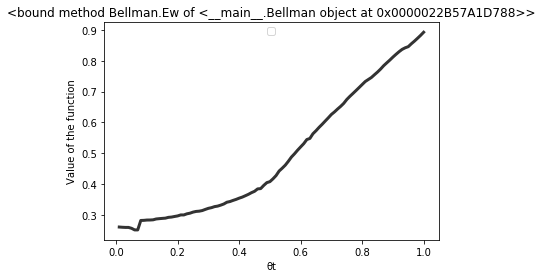

No handles with labels found to put in legend.


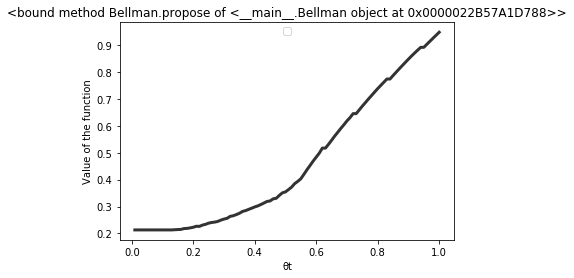

No handles with labels found to put in legend.


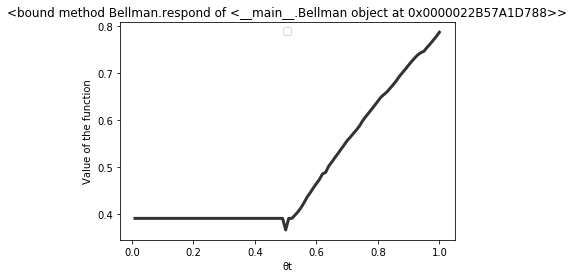

In [99]:
graf_func(θs_vals, 1, 's', s.Ew)
graf_func(θs_vals, 1, 's', s.propose)
graf_func(θs_vals, 1, 's', s.respond)

In [50]:
#gráfico das propostas

def graf_proposal(function, function_name, t, xlabel, ylabel):
    

    grid_graf = len(θs_vals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(θs_vals):
        for j, lj in enumerate(lj_vals):
            graf[i,j] = function(θs, θs, lj, t)[1]


    fig, ax = plt.subplots()

    cs1 = ax.contourf(θs_vals, lj_vals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(θs_vals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
    plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.ticklabel_format(useOffset=False)


    plt.show()

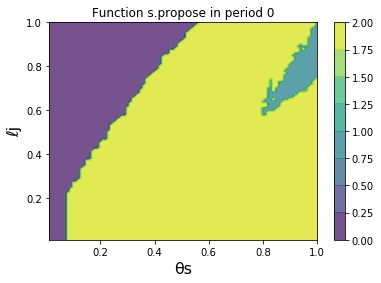

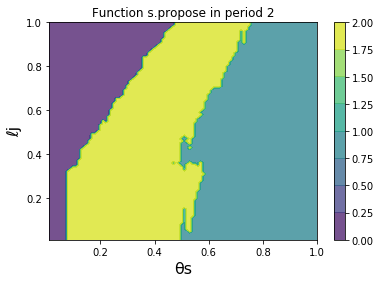

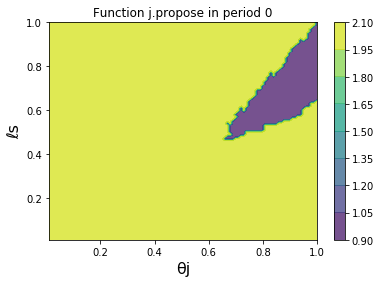

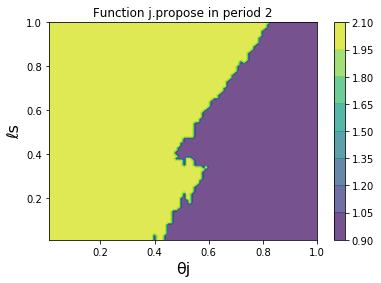

In [51]:
graf_proposal(s.propose,'s.propose', 0, 'θs', 'ℓj')

graf_proposal(s.propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal(j.propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal(j.propose, 'j.propose', 2, 'θj', 'ℓs')

In [94]:
#gráfico das propostas

def graf_proposal2(function, function_name, t, xlabel, ylabel):
    #tentei plt.imshow() e não funfou

    grid_graf = len(θs_vals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(θs_vals):
        for j, lj in enumerate(lj_vals):
            graf[i,j] = function(θs, θs, lj, t)[1]


    fig, ax = plt.subplots()

#     cs1 = ax.contourf(θs_vals, lj_vals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(θs_vals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
#     plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

#     ax.ticklabel_format(useOffset=False)
    
    
#     rgb = plt.get_cmap('jet')(graf)
#     ax.scatter(θs_vals, ℓs_vals, color = graf)

    # make a color map of fixed colors
#     cmap = mpl.colors.ListedColormap(['black', 'blue', 'red'])
#     bounds=[0,2]
#     norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


#     # tell imshow about color map so that only set colors are used
#     img = plt.imshow(graf.T,interpolation='nearest',
#                     cmap = cmap)
    
    
#     # make a color bar
#     plt.colorbar(img,cmap=cmap,boundaries=bounds,ticks=[0,1,2])

#     cmap = mpl.colors.ListedColormap(['black','blue', 'red'])
    plt.pcolor(θs_vals, θs_vals, graf.T, edgecolors='white', linewidths=0.01)


    plt.show()

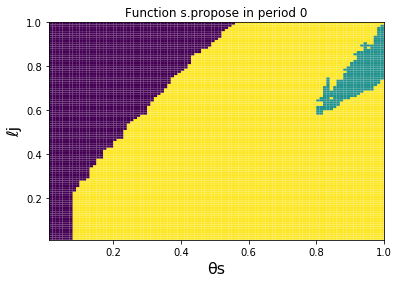

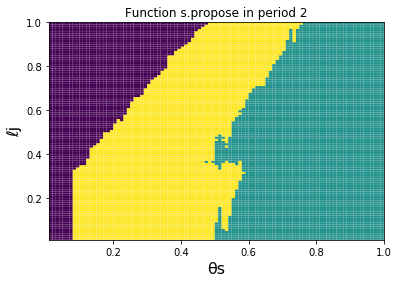

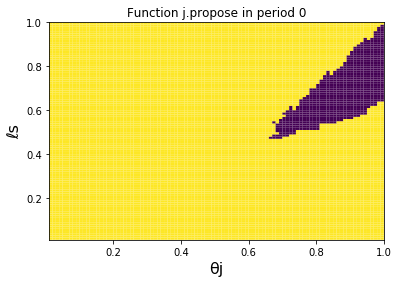

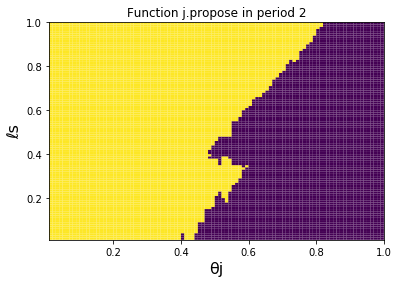

In [95]:
graf_proposal2(s.propose,'s.propose', 0, 'θs', 'ℓj')

graf_proposal2(s.propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal2(j.propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal2(j.propose, 'j.propose', 2, 'θj', 'ℓs')

# Passo 5: resolvendo a negociação entre os credores

Aqui vamos resolver o jogo de fato.

Etapas:

1. Os dois credores recebem suas habilidades, que são informação privada
2. Um credor é sorteado para propor o que fazer com a firma
3. Há uma atualização nos lower bounds das habilidades para o próximo período
4. Usando os lower bounds do próximo período, o credor propositor faz uma oferta baseado no valor de continuação esperado para o próximo período (o dele próprio e o do adversário)
5. Há uma atualização das habilidades verdadeiras para o próximo período, que são informação privada
6. O credor respondente olha a sua habilidade para o próximo período, os lower bounds do próximo período, calcula seu valor de continuação do próximo período e dá uma resposta.
4. O jogo acaba quando os dois concordam quanto ao que fazer com a firma


O resultado final é um vetor contendo 3 coisas:
1. A taxa de recuperação de crédito (o quanto cada credor recebeu em relação ao que ele tinha de crédito)
2. Em qual turno a negociação acabou
3. O que decidiram fazer com a firma (reorganizar ou liquidar)



#### Barganha completa: com s ou j propondo

In [ ]:
#loop while resultado[3] diferente de t, continua



#parâmetros iniciais
t = 0

θst = θ_s0
θjt = θ_j0

#assumindo que lower bounds nos períodos iniciais são as próprias habilidades iniciais
lst = θ_s0
ljt = θ_j0


#vetor com payoff de s, payoff de j, destino da firma e período
#destino da firma é 0 (liquidou) ou 1 (reorganizou)
resultado = np.zeros(4)


#loop roda enquanto não encerrarem o jogo
#o payoff dos jogadores só é gravado no resultado o jogo acaba. 
#Então o loop vai rodar até que o payoff seja diferente do valor inicial, que é zero
while(resultado[0] == 0):
    




    #sorteio do jogador proponente

    u = uniform(0, 1)

    if(u < λj):
        propositor = 'j'

    else:
        propositor = 's'



    if(propositor == 's'):
        



        # se s é chamado a propor ####

        #proposta
        # 0 é liquidar
        # 1 é reorganizar
        # 2 é esperar

        proposta = St(θst, lst, ljt, t)[1]

        payoff_s = St(θst, lst, ljt, t)[0]

        #update dos lower bounds
        ls_next = St(θst, lst, ljt, t)[2]

        #lj_next não pode alterar caso a proposta seja de espera, pois não há cutoff
        lj_next = St(θst, lst, ljt, t)[3]


        #jeito resumido
        # [payoff_s, proposta, ls_next, lj_next] = St(θst, lst, ljt, 0)[1:]

        #update das habilidades à tarde
        θs_next = round(draw_beta(θst), 2)
        θj_next = round(draw_beta(θjt), 2)



        if(proposta == 0):

            #o que j faz se s propor liquidar?
            #j olha sua habilidade e os lower bounds do próximo período e calcula o valor de continuação
            #aqui ele olha o valor de continuação dele de fato, sem ser valor esperado. Então a função é diferente de j_liq

            jt_liq_valor = [Lj(t), V[t] * θj_next - Ls(t) ]

            resposta = np.argmax(jt_liq_valor)

            payoff_j = jt_liq_valor[resposta]


            if(resposta == 0):
                #j concorda em liquidar
                #payoffs são os de liquidação

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 0 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j prefere reorganizar
                #payoff de s é liq, payoff de j é de reorganização

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #1 é caso reorganize
                resultado[3] = t 

            #em qualquer cenário, quando o oponente propôe liquidar o jogo acaba. Por isso sempre temos resultado[3] = t

        if(proposta == 1):
            #o que j faz se s propor reorganizar?

            #a proposta de pagamento de s é o valor esperado da função valor de j, com base nas informações que s tem hoje
            Pst = Ewj(expec_beta(lj_next), ls_next, lj_next, t+1)

            jt_reorg_valor = [Pst, Ewj(θj_next, ls_next, lj_next, t+1)]

            resposta = np.argmax(jt_reorg_valor)

            payoff_j = jt_reorg_valor[resposta]



            if(resposta == 0):
                #j concorda com a proposta de pagamento

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j recusa a proposta de pagamento
                #jogo vai para o próximo período
                #vai para o próximo período

                t += 1

                #update das informações
                θst = θs_next
                θjt = θj_next
                lst = ls_next
                ljt = lj_next


        if(proposta == 2):
            #o que acontece se s propor esperar?
            #vai para o próximo período

            t += 1

            #update das informações
            θst = θs_next
            θjt = θj_next
            lst = ls_next
            #ljt não sofre alteração na proposta de esperar


    #============================================================================
    else: #caso quem proponha seja j


        # se j é chamado a propor ####

        #proposta
        # 0 é liquidar
        # 1 é reorganizar
        # 2 é esperar

        proposta = Jt(θst, lst, ljt, t)[1]

        payoff_j = Jt(θst, lst, ljt, t)[0]

        #update dos lower bounds
        ls_next = Jt(θst, lst, ljt, t)[2]

        #ls_next não pode alterar caso a proposta seja de espera, pois não há cutoff
        lj_next = Jt(θst, lst, ljt, t)[3]


        #jeito resumido


        #update das habilidades à tarde
        θs_next = round(draw_beta(θst), 2)
        θj_next = round(draw_beta(θjt), 2)



        if(proposta == 0):

            #o que j faz se s propor liquidar?
            #j olha sua habilidade e os lower bounds do próximo período e calcula o valor de continuação
            #aqui ele olha o valor de continuação dele de fato, sem ser valor esperado. Então a função é diferente de j_liq

            st_liq_valor = [Ls(t), V[t] * θs_next - Lj(t) ]

            resposta = np.argmax(st_liq_valor)

            payoff_s = st_liq_valor[resposta]


            if(resposta == 0):
                #j concorda em liquidar
                #payoffs são os de liquidação

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 0 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j prefere reorganizar
                #payoff de s é liq, payoff de j é de reorganização

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #1 é caso reorganize
                resultado[3] = t 

            #em qualquer cenário, quando o oponente propôe liquidar o jogo acaba. Por isso sempre temos resultado[3] = t

        if(proposta == 1):
            #o que s faz se j propor reorganizar?

            Pjt = Ews(expec_beta(ls_next), ls_next, lj_next, t+1)

            st_reorg_valor = [Pjt, Ews(θs_next, ls_next, lj_next, t+1)]

            resposta = np.argmax(st_reorg_valor)

            payoff_s = st_reorg_valor[resposta]



            if(resposta == 0):
                #s concorda com a proposta de pagamento

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #s recusa a proposta de pagamento
                #jogo vai para o próximo período

                t += 1

                #update das informações
                θst = θs_next
                θjt = θj_next
                lst = ls_next
                ljt = lj_next


        if(proposta == 2):
            #o que acontece se s propor esperar?
            #vai para o próximo período

            t += 1

            #update das informações
            θst = θs_next
            θjt = θj_next
            ljt = lj_next
            #lst não sofre alteração na proposta de esperar


In [ ]:
θst
θjt

resultado

proposta

t
propositor

#agora falta fazer a média dos valores de negociação para colocar como um momento



# Próximos passos



* HIGIENIZAR O CÓDIGO, DEIXAR ORGANIZADO!


* ~debugar o que acontece quando t = 14~
    * bug na função pmf, e acho que vem da função bins() também


* ~criar função de esperança baseada na função beta~
    * expec_beta(info_hoje) retorna o valor esperado de teta amanhã




* ~discretizar a beta para obter a esperança das funções valor no período seguinte~



* ~fazer Js_val~

* ~guardar resultados de Js_val e Ws_val do último período numa  matriz 4D~

* ~pensar numa função Js_next para achar o valor de Js no próximo período baseado nos parâmetros deste período~
    * regra para atualização de lst
    * regra para atualização de ljt
    * expectativa da habilidade no período seguinte

* ~pensar na forma recursiva do jogo~
    * acho que as funções probabilidade também têm que considerar o update do lower bound, pois elas fazem parte do cenário onde o jogador não propõe


* checar todas as funções de cálculo do jogo (Passo 3)


* considerar a estrutura de negociação do jogo

* aumentar a precisão das estimativas do jogo
    * algoritmo para cálculo do cutoff pode ter mais casas decimais
    
    
 * fazer uma estrutura mais enxuta, com uma função que tome como argumento se é s ou j. Ao invés de criar St, Jt, st, jt...
    


* passos finais
    * replicar os gráficos do artigo de referência


### Conferir novamente

1. ~Se preciso usar ls_next e lj_next nas funções Prob_s e Prob_j~ 
   * conferi e precisa sim, já arrumei

2. Se o valor esperado da função para calcular os thresholds cst e cjt estão corretos

3. A função pmf não está somando um, tem que verificar onde está o erro

